# 定义VGG和FCN网络

In [1]:
import torch.nn as nn
from torchvision.models.vgg import VGG
from torchvision import models
import torch.nn.functional as F
import torch

In [2]:
# 下面开始定义网络模型
# 先定义VGG结构

# ranges 是用于方便获取和记录每个池化层得到的特征图
# 例如vgg16，需要(0, 5)的原因是为方便记录第一个pooling层得到的输出(详见下面VGG定义)
ranges = {
    'vgg11': ((0, 3), (3, 6), (6, 11), (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

# Vgg网络结构配置（数字代表经过卷积后的channel数，‘M’代表卷积层）
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [3]:
# 由cfg构建vgg-Net的卷积层和池化层(block1-block5)
def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


In [4]:
# 下面开始构建VGGnet
class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super().__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        # 获取VGG模型训练好的参数，并加载（第一次执行需要下载一段时间）
        if pretrained:
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        # 去掉vgg最后的全连接层(classifier)
        if remove_fc:
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}
        # 利用之前定义的ranges获取每个maxpooling层输出的特征图
        for idx, (begin, end) in enumerate(self.ranges):
            # self.ranges = ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)) (vgg16 examples)
            # vgg16有5个卷积块，每个卷积块的最后一层是pooling，即第0~4是卷积、激活、卷积、激活，第5层是池化
            # 第三个卷积块是三次卷积三次激活后一次pooling
            for layer in range(begin, end):
                x = self.features[layer](x)
            output["x%d" % (idx + 1)] = x
        # output 为一个字典键x1d对应第一个maxpooling输出的特征图，x2...x5类推
        return output


In [5]:
# 下面由VGG构建FCN8s
class FCN8s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        """pretrained_net:预训练的网络;
        n_class:分类数"""
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.conv6 = nn.Conv2d(512, 512, kernel_size=1, stride=1, padding=0, dilation=1)
        self.conv7 = nn.Conv2d(512, 512, kernel_size=1, stride=1, padding=0, dilation=1)
        self.relu = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1 = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # maxpooling5的feature map (1/32)
        x4 = output['x4']  # maxpooling4的feature map (1/16)
        x3 = output['x3']  # maxpooling3的feature map (1/8)

        score = self.relu(self.conv6(x5))  # conv6  size不变 (1/32)
        score = self.relu(self.conv7(score))  # conv7  size不变 (1/32)
        # score是conv7,升采样一次后变成1/16与x4相加
        score = self.relu(self.deconv1(score))  # out_size = 2*in_size (1/16)
        score = self.bn1(score + x4)
        # score现在是1/16，升采样后变成1/8与x3相加
        score = self.relu(self.deconv2(score))  # out_size = 2*in_size (1/8)
        score = self.bn2(score + x3)
        # score现在是1/8
        score = self.bn3(self.relu(self.deconv3(score))) 
        # score现在是1/4
        score = self.bn4(self.relu(self.deconv4(score)))  
        # score现在是1/2
        score = self.bn5(self.relu(self.deconv5(score)))  
        # score现在是1/1，恢复到原来的尺寸
        score = self.classifier(score)  
        # size不变，使输出的channel等于类别数

        return score

# 加载训练数据

In [6]:
import os
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np

In [7]:
# 利用torch提供的Dataset类，定义我们自己的数据集
import pandas as pd
data = pd.read_csv('imgpath.csv')
print(data.img_path[0])
print(data.mask_path[0])
class BagDataset(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __len__(self):
        return len(data)

    def __getitem__(self, idx):
        img_name = data.img_path[idx]
        imgA = cv2.imread(img_name)
        imgA = cv2.resize(imgA, (640, 160))
        mask_name = data.mask_path[idx]
        imgB = cv2.imread(mask_name, 0)
        imgB = cv2.resize(imgB, (640, 160))
        imgB[imgB==76] = 1
        imgB[imgB>1] = 2
        imgB = imgB.astype('uint8')
        imgB = torch.FloatTensor(imgB)
        # print(imgB.shape)
        if self.transform:
            imgA = self.transform(imgA)
        return imgA, imgB


./data_road/training/image_2/umm_000000.png
./data_road/training/gt_image_2/umm_road_000000.png


# 训练FCN8S网络

In [8]:
from datetime import datetime
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

In [9]:
# 在训练网络前定义函数用于计算Acc 和 mIou
# 计算混淆矩阵
def _fast_hist(label_true, label_pred, n_class):
    # mask把符合分类属性的位置取出来
    # label_true和label_pred中最大值均为n_class-1，
    # np.bincount统计各个数出现的次数，返回长度为序列最大值+1，
    # minlength是返回的最大长度，小于最大值+1时无效，此处minlength = n_class**2，和混淆矩阵尺寸相同
    # 返回一个n_class行n_class列的混淆矩阵，行是实际值，列是预测值
    # hist计算中最大值为(n_class-1)*n_class+n_class，即n_class**2，以n_class=3为例
    # 两者相加=0，实际为0，表示预测为0，
    # 两者相加=1，实际为0，表示预测为1，
    # 两者相加=2，实际为0，表示预测为2，
    # 两者相加=3，实际为1，表示预测为0，
    # 两者相加=4，实际为1，表示预测为1，
    # 两者相加=5，实际为1，表示预测为2，
    # 两者相加=6，实际为2，表示预测为0，
    # 两者相加=7，实际为2，表示预测为1，
    # 两者相加=8，实际为2，表示预测为2，
    # np.bincount用于统计各个数值的个数，reshape后就是混淆矩阵
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * label_true[mask].astype(int) +
        label_pred[mask], minlength=n_class ** 2).reshape(n_class, n_class)
    return hist

In [10]:
# 根据混淆矩阵计算Acc和mIou
def label_accuracy_score(label_trues, label_preds, n_class):
    # 生成混淆矩阵形状的矩阵
    hist = np.zeros((n_class, n_class))
    # 计算各个批次结果的混淆矩阵和
    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
    # np.diag把对角线的值取出来（即分类正确的个数）求和，并除以总数，即正确率
    acc = np.diag(hist).sum() / hist.sum()
    # 忽略错误的情况下，计算每一类的正确率
    with np.errstate(divide='ignore', invalid='ignore'):
        acc_cls = np.diag(hist) / hist.sum(axis=1)
    # 忽略nan的求平均
    acc_cls = np.nanmean(acc_cls)
    # axis=1表示按行求和，表示实际某类的个数，
    # axis=0表示按列求和，表示预测某类的个数，
    # 相加之后正好多加了一次对角线的数，因此减去对角线
    # 相除之后表示某个类别预测正确的占正确的和错误的总和的比值
    with np.errstate(divide='ignore', invalid='ignore'):
        iu = np.diag(hist) / (
                hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist)
        )
    # 忽略nan的求平均
    mean_iu = np.nanmean(iu)
    return acc, acc_cls, mean_iu

In [24]:
class FocalLoss(nn.Module):
    def __init__(self, class_num, alpha=0.25, gamma=2, size_average=True):
        super(FocalLoss, self).__init__()
        if alpha is None:
            self.alpha = torch.ones(class_num, 1)
        else:
            self.alpha = torch.tensor(alpha, requires_grad=True)
        self.gamma = gamma
        self.class_num = class_num
        self.size_average = size_average
        
    def forward(self, inputs, targets):
        # inputs.shape = (N,C,H,W)
        N,C,H,W = inputs.shape
        # 将inputs的形状变成N,H,W,C
        inputs = inputs.permute([0,2,3,1])
        # 第三维进行softmax
        P = F.softmax(inputs,dim=3) 

        # one hot start
        # 生成和cross_entropy一样的shape形状,N,H,W,C
        class_mask = inputs.data.new(N,H,W,self.class_num).fill_(0)  
        # 需要更新，所以加入梯度计算
        class_mask = class_mask.requires_grad_() 
        # 取得目标的索引，前三维要与class_mask一致
        ids = targets.view(N,H,W,1) 
        # 利用scatter将ids的索引值将mask最后一个维度变成onehot，
        class_mask.data.scatter_(3, ids.data, 1)
        # one hot end

        if inputs.is_cuda and not self.alpha.is_cuda:
            self.alpha = self.alpha.cuda()

        # 采用统一的alpha值
        alpha = self.alpha
        
        probs = (P*class_mask).sum(3).view(N,H,W,1) 
        # 将softmax * one_hot格式，0的部分被消除，留下1的概率，即每个target的概率
        
        log_p = probs.log()
        # 取得对数
        
        batch_loss = -alpha*(torch.pow((1-probs), self.gamma))*log_p 
        # batch_loss就是取每一个batch的loss值
        
        
        # 最终将每一个batch的loss加总后平均
        if self.size_average:
            loss = batch_loss.mean()
        else:
            loss = batch_loss.sum()
        return loss

In [25]:
# 定义训练函数
def train(fcn_model,epo_num=50,n_class=3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    fcn_model = fcn_model.to(device)
    # 定义交叉熵损失函数
    criterion = FocalLoss(n_class).to(device)
    optimizer = optim.Adam(fcn_model.parameters(), lr=1e-3)
    
    # 记录训练过程相关指标
    all_train_iter_loss = []
    all_test_iter_loss = []
    test_Acc = []
    test_mIou = []
    # 记录开始时间
    prev_time = datetime.now()

    for epo in range(epo_num):

        # 训练
        train_loss = 0
        fcn_model.train()
        for index, (road, road_msk) in enumerate(train_dataloader):
            # road.shape = torch.Size([4, 3, 160, 640])
            # road_msk.shape = torch.Size([4,160,640])

            road = road.to(device)
            road_msk = road_msk.to(device)

            optimizer.zero_grad()
            output = fcn_model(road)


            loss = criterion(output, road_msk.long())
            loss.backward()  
            # 需要计算导数，则调用backward
            iter_loss = loss.item()  
            # .item()返回一个具体的值，一般用于loss和acc
            all_train_iter_loss.append(iter_loss)
            train_loss += iter_loss
            optimizer.step()

            output_np = output.cpu().detach().numpy().copy()
            output_np = np.argmax(output_np, axis=1)
            road_msk_np = road_msk.cpu().detach().numpy().copy()

            # 每15个bacth，输出一次训练过程的数据
            if np.mod(index, 15) == 0:
                print('epoch {}, {}/{},train loss is {}'.format(epo, index, len(train_dataloader), iter_loss))

        # 验证
        test_loss = 0
        fcn_model.eval()
        with torch.no_grad():
            for index, (road, road_msk) in enumerate(test_dataloader):
                road = road.to(device)
                road_msk = road_msk.to(device)

                optimizer.zero_grad()
                output = fcn_model(road)
                loss = criterion(output, road_msk.long())
                iter_loss = loss.item()
                all_test_iter_loss.append(iter_loss)
                test_loss += iter_loss

                # 把值小的那个位置取出来，即取出分类
                output_np = output.cpu().detach().numpy().copy()
                output_np = np.argmax(output_np, axis=1)
                road_msk_np = road_msk.cpu().detach().numpy().copy()

        cur_time = datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        prev_time = cur_time

        print('<---------------------------------------------------->')
        print('epoch: %d' % epo)
        print('epoch train loss = %f, epoch test loss = %f, %s'\
              % (train_loss / len(train_dataloader), test_loss / len(test_dataloader), time_str))

        acc, acc_cls, mean_iu = label_accuracy_score(road_msk_np, output_np, n_class)
        test_Acc.append(acc)
        test_mIou.append(mean_iu)

        print('Acc = %f, mIou = %f' % (acc, mean_iu))
        # 每5个epoch存储一次模型
        if not os.path.exists('checkpoints'):
            os.mkdir('checkpoints')
        if np.mod(epo+1, 5) == 0:
            # 只存储模型参数
            torch.save(fcn_model.state_dict(), 'checkpoints/fcn_model_Focalloss_{}.pth'.format(epo+1))
            print('saveing checkpoints/fcn_model_{}.pth'.format(epo+1))

    # 绘制训练过程数据
    plt.figure()
    plt.subplot(221)
    plt.title('train_loss')
    plt.plot(all_train_iter_loss)
    plt.xlabel('batch')
    plt.subplot(222)
    plt.title('test_loss')
    plt.plot(all_test_iter_loss)
    plt.xlabel('batch')
    plt.subplot(223)
    plt.title('test_Acc')
    plt.plot(test_Acc)
    plt.xlabel('epoch')
    plt.subplot(224)
    plt.title('test_mIou')
    plt.plot(test_mIou)
    plt.xlabel('epoch')
    plt.show()

epoch 0, 0/65,train loss is 0.1482519805431366
epoch 0, 15/65,train loss is 0.1034633070230484
epoch 0, 30/65,train loss is 0.07473604381084442
epoch 0, 45/65,train loss is 0.07466163486242294
epoch 0, 60/65,train loss is 0.0467420369386673
<---------------------------------------------------->
epoch: 0
epoch train loss = 0.079255, epoch test loss = 0.038646, Time 00:00:11
Acc = 0.862686, mIou = 0.500026
epoch 1, 0/65,train loss is 0.03732207044959068
epoch 1, 15/65,train loss is 0.031950581818819046
epoch 1, 30/65,train loss is 0.022999772801995277
epoch 1, 45/65,train loss is 0.027500761672854424
epoch 1, 60/65,train loss is 0.01887604221701622
<---------------------------------------------------->
epoch: 1
epoch train loss = 0.032283, epoch test loss = 0.024352, Time 00:00:11
Acc = 0.908936, mIou = 0.550208
epoch 2, 0/65,train loss is 0.021489514037966728
epoch 2, 15/65,train loss is 0.0276227667927742
epoch 2, 30/65,train loss is 0.028374748304486275
epoch 2, 45/65,train loss is 0.

epoch 19, 45/65,train loss is 0.0031582596711814404
epoch 19, 60/65,train loss is 0.0021992307156324387
<---------------------------------------------------->
epoch: 19
epoch train loss = 0.002881, epoch test loss = 0.032578, Time 00:00:11
Acc = 0.914570, mIou = 0.522164
saveing checkpoints/fcn_model_20.pth
epoch 20, 0/65,train loss is 0.002353757619857788
epoch 20, 15/65,train loss is 0.0022241147235035896
epoch 20, 30/65,train loss is 0.0025553833693265915
epoch 20, 45/65,train loss is 0.0036506205797195435
epoch 20, 60/65,train loss is 0.0016726806061342359
<---------------------------------------------------->
epoch: 20
epoch train loss = 0.002653, epoch test loss = 0.033305, Time 00:00:11
Acc = 0.915752, mIou = 0.464182
epoch 21, 0/65,train loss is 0.0015846508322283626
epoch 21, 15/65,train loss is 0.0017126506427302957
epoch 21, 30/65,train loss is 0.002124866470694542
epoch 21, 45/65,train loss is 0.002521326532587409
epoch 21, 60/65,train loss is 0.002857575658708811
<--------

epoch 38, 45/65,train loss is 0.0008840766968205571
epoch 38, 60/65,train loss is 0.0013680087868124247
<---------------------------------------------------->
epoch: 38
epoch train loss = 0.001224, epoch test loss = 0.043661, Time 00:00:11
Acc = 0.890312, mIou = 0.625549
epoch 39, 0/65,train loss is 0.0012106506619602442
epoch 39, 15/65,train loss is 0.0011192697566002607
epoch 39, 30/65,train loss is 0.0006747909355908632
epoch 39, 45/65,train loss is 0.0009213353623636067
epoch 39, 60/65,train loss is 0.0019948421977460384
<---------------------------------------------------->
epoch: 39
epoch train loss = 0.001237, epoch test loss = 0.038574, Time 00:00:11
Acc = 0.969424, mIou = 0.613282
saveing checkpoints/fcn_model_40.pth
epoch 40, 0/65,train loss is 0.001145042129792273
epoch 40, 15/65,train loss is 0.0011476107174530625
epoch 40, 30/65,train loss is 0.0010465494124218822
epoch 40, 45/65,train loss is 0.0009021381847560406
epoch 40, 60/65,train loss is 0.0013772224774584174
<-----

epoch 57, 45/65,train loss is 0.000756728055421263
epoch 57, 60/65,train loss is 0.0007063986267894506
<---------------------------------------------------->
epoch: 57
epoch train loss = 0.000671, epoch test loss = 0.051568, Time 00:00:11
Acc = 0.925146, mIou = 0.475744
epoch 58, 0/65,train loss is 0.000657219672575593
epoch 58, 15/65,train loss is 0.0005685832584276795
epoch 58, 30/65,train loss is 0.0005612621316686273
epoch 58, 45/65,train loss is 0.000606029643677175
epoch 58, 60/65,train loss is 0.0004987397696822882
<---------------------------------------------------->
epoch: 58
epoch train loss = 0.000618, epoch test loss = 0.052305, Time 00:00:11
Acc = 0.921016, mIou = 0.528445
epoch 59, 0/65,train loss is 0.0005275228759273887
epoch 59, 15/65,train loss is 0.000446062273113057
epoch 59, 30/65,train loss is 0.0003433804085943848
epoch 59, 45/65,train loss is 0.0006851176731288433
epoch 59, 60/65,train loss is 0.0006021327571943402
<---------------------------------------------

epoch 76, 30/65,train loss is 0.0004217289970256388
epoch 76, 45/65,train loss is 0.0003213304153177887
epoch 76, 60/65,train loss is 0.0004591531178448349
<---------------------------------------------------->
epoch: 76
epoch train loss = 0.000472, epoch test loss = 0.052086, Time 00:00:11
Acc = 0.966182, mIou = 0.731405
epoch 77, 0/65,train loss is 0.00044049762072972953
epoch 77, 15/65,train loss is 0.00038995122304186225
epoch 77, 30/65,train loss is 0.0003334708162583411
epoch 77, 45/65,train loss is 0.00035011928412131965
epoch 77, 60/65,train loss is 0.0004329029470682144
<---------------------------------------------------->
epoch: 77
epoch train loss = 0.000398, epoch test loss = 0.057700, Time 00:00:11
Acc = 0.923945, mIou = 0.584697
epoch 78, 0/65,train loss is 0.0002369596913922578
epoch 78, 15/65,train loss is 0.0002981887955684215
epoch 78, 30/65,train loss is 0.0004358626902103424
epoch 78, 45/65,train loss is 0.00020451344607863575
epoch 78, 60/65,train loss is 0.000313

epoch 95, 15/65,train loss is 0.00019872172561008483
epoch 95, 30/65,train loss is 0.00018045786418952048
epoch 95, 45/65,train loss is 0.0002917757083196193
epoch 95, 60/65,train loss is 0.00015612183779012412
<---------------------------------------------------->
epoch: 95
epoch train loss = 0.000214, epoch test loss = 0.064336, Time 00:00:11
Acc = 0.923359, mIou = 0.575151
epoch 96, 0/65,train loss is 0.00017357520118821412
epoch 96, 15/65,train loss is 0.00021118161384947598
epoch 96, 30/65,train loss is 0.00015705691475886852
epoch 96, 45/65,train loss is 0.00030686770332977176
epoch 96, 60/65,train loss is 0.00014202565944287926
<---------------------------------------------------->
epoch: 96
epoch train loss = 0.000217, epoch test loss = 0.063832, Time 00:00:11
Acc = 0.924395, mIou = 0.714628
epoch 97, 0/65,train loss is 0.00024537634453736246
epoch 97, 15/65,train loss is 0.00020726851653307676
epoch 97, 30/65,train loss is 0.0002435722853988409
epoch 97, 45/65,train loss is 0.

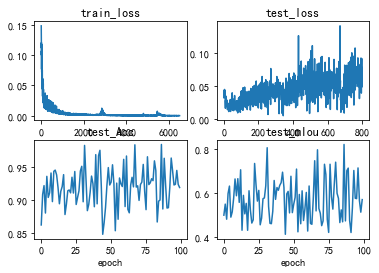

In [26]:
# torch.cuda.empty_cache()
### 利用torchvision提供的transform，定义原始图片的预处理步骤（转换为tensor和标准化处理）
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.35,0.35,0.35], std=[0.30, 0.30, 0.30])])
# 实例化数据集
road = BagDataset(transform)

train_size = int(0.9 * len(road))
test_size = len(road) - train_size
train_dataset, test_dataset = random_split(road, [train_size, test_size])

# 利用DataLoader生成一个分batch获取数据的可迭代对象
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)
vgg_model = VGGNet(requires_grad=False,show_params=False)
# # 仅采用FCN8s进行训练
fcn_model = FCN8s(pretrained_net=vgg_model, n_class=3)
train(fcn_model,epo_num=100,n_class=3)

In [27]:
import moxing as mox
mox.file.copy_parallel('/home/ma-user/work/checkpoints/fcn_model_Focalloss_100.pth','obs://class-1275-42687/Lab-2210/modelarts22926584/fcn_model_Focalloss_100.pth')

INFO:root:Using MoXing-v1.15.1-92d9ed92
INFO:root:Using OBS-Python-SDK-3.1.2
